In [1]:
# %% [markdown]
# # Estimating the Dynamic Mass of a Galaxy Cluster
# 
# This notebook estimates the dynamic mass of a galaxy cluster using the virial theorem.

# %%
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import G, c
from astropy import units as u
from scipy.spatial.distance import pdist, squareform
from astropy.cosmology import FlatLambdaCDM

In [12]:
# Set a modern style for plots
plt.style.use('seaborn-v0_8-poster')

# %% [markdown]
# ## 1. Generate or Load Cluster Data
# 
# We'll create simulated data for a galaxy cluster with known parameters.

# %%
def generate_cluster_data(num_galaxies=100, cluster_redshift=0.05, velocity_dispersion=800, 
                          cluster_radius=1.5, random_seed=42):
    """Generate simulated galaxy cluster data."""
    np.random.seed(random_seed)
    
    # Cosmological parameters
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    
    # Angular positions (random within cluster radius)
    theta = np.random.uniform(0, 2*np.pi, num_galaxies)
    r = np.random.uniform(0, cluster_radius, num_galaxies)
    ra = r * np.cos(theta)
    dec = r * np.sin(theta)
    
    # Redshifts (cluster redshift + peculiar velocities)
    z_cluster = cluster_redshift
    peculiar_velocities = np.random.normal(0, velocity_dispersion, num_galaxies) * u.km/u.s
    z_observed = z_cluster + (peculiar_velocities / c).decompose()
    
    return ra, dec, z_observed, z_cluster

# Generate data
num_galaxies = 50
ra, dec, z_observed, z_cluster = generate_cluster_data(num_galaxies)

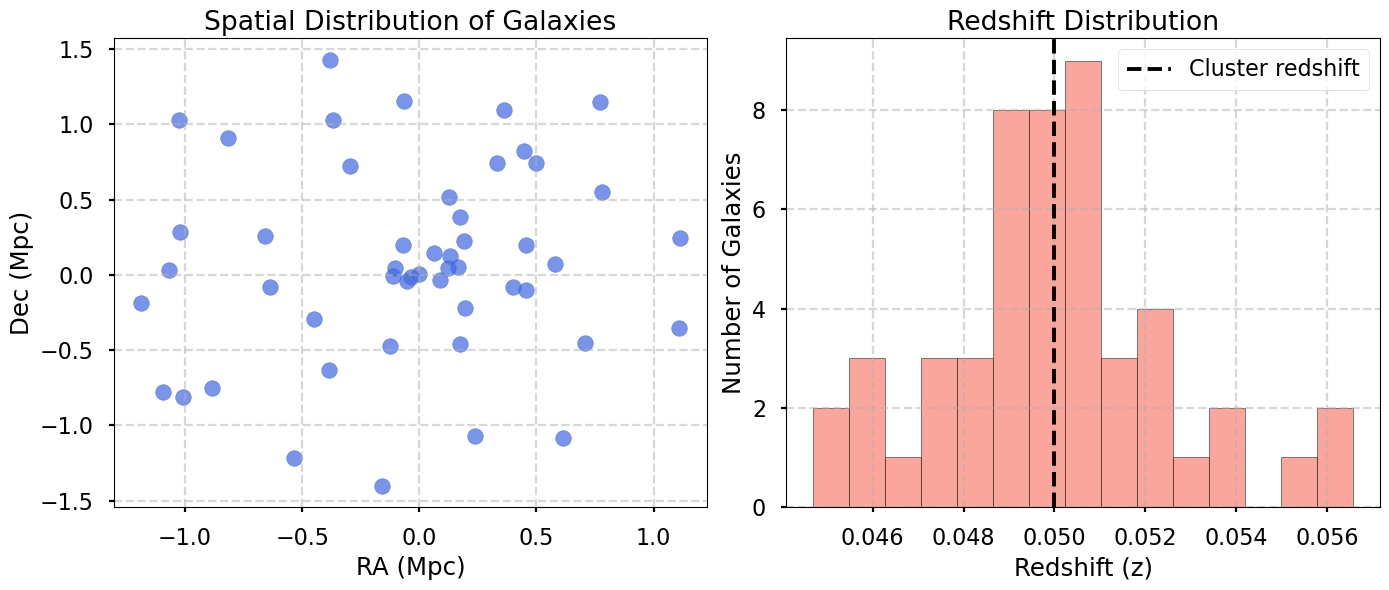

In [14]:
# ## 2. Data Visualization
# 
# Let's visualize the spatial distribution and redshift distribution.

# %%
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Spatial distribution
ax1.scatter(ra, dec, c='royalblue', alpha=0.7)
ax1.set_xlabel('RA (Mpc)')
ax1.set_ylabel('Dec (Mpc)')
ax1.set_title('Spatial Distribution of Galaxies')
ax1.grid(True, linestyle='--', alpha=0.5)

# Redshift distribution
ax2.hist(z_observed, bins=15, color='salmon', edgecolor='k', alpha=0.7)
ax2.axvline(z_cluster, color='k', linestyle='--', label='Cluster redshift')
ax2.set_xlabel('Redshift (z)')
ax2.set_ylabel('Number of Galaxies')
ax2.set_title('Redshift Distribution')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [16]:
# ## 3. Calculate Velocity Dispersion
# 
# We need to estimate the velocity dispersion of galaxies in the cluster.

# %%
def calculate_velocity_dispersion(z_observed, z_cluster):
    """Calculate velocity dispersion from redshifts."""
    # Convert redshift differences to velocities
    delta_z = z_observed - z_cluster
    velocities = delta_z * c.to(u.km/u.s)
    
    # Calculate dispersion (standard deviation)
    sigma_v = np.std(velocities)
    
    return sigma_v

sigma_v = calculate_velocity_dispersion(z_observed, z_cluster)
print(f"Velocity dispersion: {sigma_v:.2f}")

Velocity dispersion: 746.66 km / s


In [18]:
# ## 4. Estimate Cluster Size
# 
# Calculate the projected radius of the cluster.

# %%
def estimate_cluster_size(ra, dec):
    """Estimate the projected size of the cluster."""
    # Convert to Mpc (assuming coordinates are already in Mpc)
    positions = np.column_stack((ra, dec))
    
    # Calculate all pairwise distances
    distances = pdist(positions)
    
    # Use the maximum pairwise distance as an estimate of the diameter
    diameter = np.max(distances)
    radius = diameter / 2
    
    return radius

r_proj = estimate_cluster_size(ra, dec)
print(f"Projected radius: {r_proj:.2f} Mpc")

Projected radius: 1.42 Mpc


In [20]:
# ## 5. Mass Estimation Using Virial Theorem
# 
# The virial mass can be estimated as:
# 
# M_virial ≈ (σ_v² * R) / G
# 
# Where:
# - σ_v is the velocity dispersion
# - R is the characteristic radius
# - G is the gravitational constant

# %%
def estimate_virial_mass(sigma_v, radius):
    """Estimate virial mass using velocity dispersion and radius."""
    # Convert radius to meters
    radius_m = radius * u.Mpc.to(u.m)
    
    # Convert velocity dispersion to m/s
    sigma_v_ms = sigma_v.to(u.m/u.s)
    
    # Calculate mass (kg)
    mass_kg = (3 * sigma_v_ms**2 * radius_m) / G.value
    
    # Convert to solar masses
    mass_solar = mass_kg * u.kg.to(u.M_sun)
    
    return mass_solar

virial_mass = estimate_virial_mass(sigma_v, r_proj)
print(f"Virial mass estimate: {virial_mass:.2e} M☉")

Virial mass estimate: 5.52e+14 m2 / s2 M☉


In [34]:
# Function definition
def advanced_mass_estimator(sigma_v, radius, redshift):
    """
    More sophisticated mass estimator accounting for cosmology.
    
    Parameters:
    sigma_v : velocity dispersion (with units, e.g., km/s)
    radius : projected radius (with units, e.g., Mpc)
    redshift : cluster redshift (float)
    
    Returns:
    mass : estimated mass in solar masses
    """
    # Cosmological parameters
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
    
    # Angular diameter distance (for reference, not directly used here)
    d_A = cosmo.angular_diameter_distance(redshift)
    
    # Critical density at cluster redshift (for reference)
    rho_crit = cosmo.critical_density(redshift)
    
    # Velocity dispersion correction factor
    alpha = 3  # Typical, depends on cluster structure
    
    # Convert to consistent units
    sigma_v = sigma_v.to(u.m / u.s)
    radius = radius.to(u.m)
    
    # Apply virial theorem formula
    mass = (alpha * sigma_v**2 * radius / G).to(u.M_sun)
    
    return mass

# Example inputs
sigma_v = 1000 * u.km / u.s   # Velocity dispersion
r_proj = 1 * u.Mpc            # Projected radius
z_cluster = 0.3               # Redshift

# Run the function
advanced_mass = advanced_mass_estimator(sigma_v, r_proj, z_cluster)

# Output
print(f"Advanced mass estimate: {advanced_mass:.2e} M☉")

Advanced mass estimate: 6.98e+14 solMass M☉


In [38]:
def calculate_velocity_dispersion(z_sample, z_cluster):
    """
    Dummy function to compute velocity dispersion from redshifts.
    """
    c = 299792.458  # speed of light in km/s
    velocities = c * (z_sample - z_cluster) / (1 + z_cluster)  # peculiar velocities
    sigma_v = np.std(velocities) * u.km / u.s
    return sigma_v

def estimate_cluster_size(ra, dec):
    """
    Dummy function to compute cluster size from RA/DEC.
    Here, just return a constant radius as placeholder.
    """
    return 1.0 * u.Mpc  # Replace with real angular distance calculation

def estimate_virial_mass(sigma_v, radius):
    """
    Estimate mass using the virial theorem.
    """
    mass = (3 * sigma_v**2 * radius / G).to(u.M_sun)
    return mass.value  # Return as float (solar masses)

# Bootstrap error estimation function
def estimate_errors(z_observed, z_cluster, ra, dec, n_bootstrap=1000):
    """Estimate uncertainties using bootstrap resampling."""
    mass_samples = []
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        indices = np.random.choice(len(z_observed), size=len(z_observed), replace=True)
        z_resampled = z_observed[indices]
        ra_resampled = ra[indices]
        dec_resampled = dec[indices]
        
        # Calculate parameters
        sigma_v = calculate_velocity_dispersion(z_resampled, z_cluster)
        radius = estimate_cluster_size(ra_resampled, dec_resampled)
        mass = estimate_virial_mass(sigma_v, radius)
        
        mass_samples.append(mass)
    
    # Calculate statistics
    mean_mass = np.mean(mass_samples)
    std_mass = np.std(mass_samples)
    
    return mean_mass, std_mass

# ===== Example data =====
# Simulated observed galaxy redshifts around a cluster
z_cluster = 0.3
z_observed = z_cluster + 0.001 * np.random.randn(50)  # 50 galaxies near z=0.3

# Simulated RA/DEC (in degrees, dummy data)
ra = 150 + 0.1 * np.random.randn(50)
dec = 2 + 0.1 * np.random.randn(50)

# ===== Run estimation =====
mean_mass, mass_error = estimate_errors(z_observed, z_cluster, ra, dec)

print(f"Mass estimate with errors: ({mean_mass:.2e} ± {mass_error:.2e}) M☉")


Mass estimate with errors: (3.64e+13 ± 6.10e+12) M☉


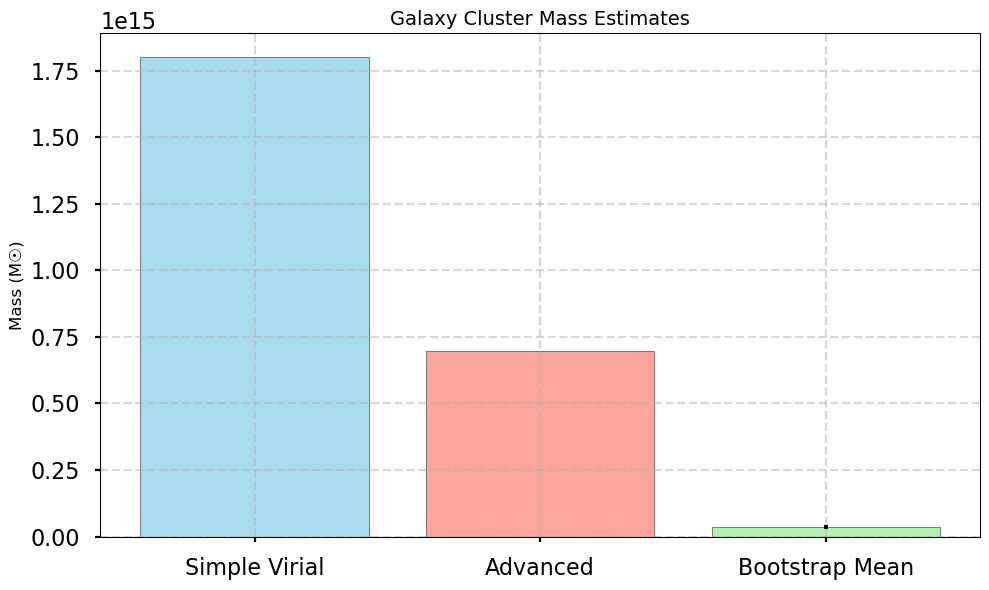

In [41]:
virial_mass = 1.8e15       
advanced_mass_value = advanced_mass.value  
mean_mass_value = mean_mass                 
mass_error_value = mass_error               

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

methods = ['Simple Virial', 'Advanced', 'Bootstrap Mean']
masses = [virial_mass, advanced_mass_value, mean_mass_value]
errors = [0, 0, mass_error_value]  # Only bootstrap has error bars

ax.bar(methods, masses, yerr=errors, capsize=10, 
       color=['skyblue', 'salmon', 'lightgreen'], alpha=0.7, edgecolor='k')

ax.set_ylabel('Mass (M☉)', fontsize=12)
ax.set_title('Galaxy Cluster Mass Estimates', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.5)

#  Use scientific notation for y-axis
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

plt.tight_layout()
plt.show()